# Reinforcement Learning for Ball Kicking in Quadruped Robot and Custom 2D Environment
### 22AIE401: Deep Reinforcement Learning
### Batch B - Group 15
### Members:
- 1. CB.EN.U4AIE21143 - Parthvi Manoj
- 2. CB.EN.U4AIE21159 - Sakthi Swaroopan S 
- 3. CB.EN.U4AIE21160 - Sanjay Chidambaram
- 4. CB.EN.U4AIE21170 - Taruneshwaran T


## Phase 1: Reinforcement Learning for Quadruped Robot for Ball Kicking (HiWonder ROSPug)
### Code is meant to be run on the HiWonder ROSPug Quadruped Robot for Ball Kicking



# THE PUPPY ROBOT CODE IS NOT MEANT TO BE RUN ON JUPYTER NOTEBOOK
## PLEASE RUN THIS CODE ON THE ROSPUG ROBOT
- Run the following commands in the terminal to run the code on the robot
```bash
systemctl stop pug_bringup.service

roscd pug_almighty/scripts

python3 RL_kick_ball.py
```


In [ ]:
#!/usr/bin/python3
# coding=utf8

import sys
import cv2
import time
import math
import threading
import pickle

import numpy as np
from enum import Enum
from pug_sdk import misc as Misc
from pug_sdk import yaml_handle

from collections import deque
import random

HomePath = '/home/hiwonder'
sys.path.append(HomePath) 
import Camera 

sys.path.append(HomePath + '/Pug_PC_Software') 
from ServoCmd import *
from ActionGroupControl import runAction, stopActionGroup
from HiwonderPuppy import HiwonderPuppy, BusServoParams

if sys.version_info.major == 2:
    print('Please run this program with python3!')
    sys.exit(0)

# Robot movement configurations
Debug = 1
img_centerx = 160
PROCESS = 'find_ball'

# Ball detection variables
ball_centerx, ball_centery = -1, -1
ball_radius = 0

puppy = HiwonderPuppy(setServoPulse=setServoPulse, servoParams=BusServoParams(), dof='12')
Stand = {'roll':math.radians(0), 'pitch':math.radians(0), 'yaw':0.000, 'height':-13, 'x_shift':0.4, 'stance_x':1, 'stance_y':0}
Bend = {'roll':math.radians(0), 'pitch':math.radians(-21), 'yaw':0.000, 'height':-13, 'x_shift':0.4, 'stance_x':1, 'stance_y':0}

PuppyPose = Bend.copy()
GaitConfig = {'overlap_time':0.2, 'swing_time':0.15, 'clearance_time':0.0, 'z_clearance':6}
PuppyMove = {'x': 0, 'y': 0, 'yaw_rate': 0}

# RL parameters
ACTIONS = ['forward', 'move_left', 'move_right']
STATE_SIZE = 2  # ball_centerx, ball_centery
ACTION_SIZE = len(ACTIONS)
LEARNING_RATE = 0.001
GAMMA = 0.95
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MEMORY_SIZE = 1000
BATCH_SIZE = 32
LOAD_MODEL = True
GOAL_DONE = False
ITERATIONS = 5

# Experience replay memory
memory = deque(maxlen=MEMORY_SIZE)

def stance(x = 0, y = 0, z = -13, x_shift = 0):# Unit CM
    # The smaller the x_shift is, the more it leans forward when walking, and the larger it is, the more it leans back. 
    # By adjusting x_shift, the balance of the puppy's walking can be adjusted.
    return np.array([
                        [x + x_shift, x + x_shift, -x + x_shift, -x + x_shift],
                        [y, y, y, y],
                        [z, z, z, z],
                    ])#Do not change the combination of this array

# Initial stance position
def initMove():
    PuppyPose = Stand.copy()
    puppy.stance_config(stance(PuppyPose['stance_x'], PuppyPose['stance_y'], PuppyPose['height'], PuppyPose['x_shift']), PuppyPose['pitch'], PuppyPose['roll'])
    time.sleep(0.5)

# Stand position
def stand_move():
    PuppyPose = Stand.copy()
    puppy.stance_config(stance(PuppyPose['stance_x'], PuppyPose['stance_y'], PuppyPose['height'], PuppyPose['x_shift']), PuppyPose['pitch'], PuppyPose['roll'])
    time.sleep(0.5)

# Find ball position (Bend down)
def find_ball_move():
    PuppyPose = Bend.copy()
    puppy.stance_config(stance(PuppyPose['stance_x'], PuppyPose['stance_y'], PuppyPose['height'], PuppyPose['x_shift']), PuppyPose['pitch'], PuppyPose['roll'])
    time.sleep(0.2)

def load_config():
    global lab_data
    lab_data = yaml_handle.get_yaml_data('/home/hiwonder/pug/src/lab_config/config/lab_config.yaml')['color_range_list']

def init():
    puppy.gait_config(overlap_time=GaitConfig['overlap_time'], swing_time=GaitConfig['swing_time'], clearance_time=GaitConfig['clearance_time'], z_clearance=GaitConfig['z_clearance'])
    puppy.start()  # Start Up
    puppy.move_stop(servo_run_time=500)
    load_config()
    initMove()

# Movement functions
def forward(speed, t):
    PuppyMove['x'] = speed
    puppy.move(x=PuppyMove['x'], y=0, yaw_rate=0)
    time.sleep(t)

def move_left(speed, t):
    PuppyMove['y'] = speed
    puppy.move(x=0, y=PuppyMove['y'], yaw_rate=0)
    time.sleep(t)

def move_right(speed, t):
    PuppyMove['y'] = -speed
    puppy.move(x=0, y=PuppyMove['y'], yaw_rate=0)
    time.sleep(t)

def stop_move(t):
    puppy.move(x=0, y=0, yaw_rate=0)
    puppy.move_stop(servo_run_time=500)
    time.sleep(t)

# Reinforcement learning
class DQNAgent:
    def __init__(self):
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON
        self.learning_rate = LEARNING_RATE
        self.gamma = GAMMA
        self.q_table = {}

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(ACTIONS)
        # Get the action with the highest Q-value for the current state
        q_values = self.q_table.get(tuple(state), np.zeros(len(ACTIONS)))
        return ACTIONS[np.argmax(q_values)]

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            # Convert state and next_state to tuples to use them as keys in q_table
            state = tuple(state)
            next_state = tuple(next_state)

            # Initialize Q-values for unseen states
            if state not in self.q_table:
                self.q_table[state] = np.zeros(len(ACTIONS))
            if next_state not in self.q_table:
                self.q_table[next_state] = np.zeros(len(ACTIONS))

            # Q-value update for the chosen action
            action_index = ACTIONS.index(action)

            # Compute the target: reward + discounted future Q-value
            if done:
                target = reward  # No future reward if the episode is done
            else:
                target = reward + self.gamma * np.max(self.q_table[next_state])

            # Q-learning update rule: update the Q-value for state-action pair
            self.q_table[state][action_index] += self.learning_rate * (target - self.q_table[state][action_index])

        # Decrease exploration over time
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)
        print('=====================================> Model SAVED to', filename)

    def load(self, filename):
        # if file doesnt exist, return an empty q_table
        try:
            with open(filename, 'rb') as f:
                self.q_table = pickle.load(f)
            print('=====================================> Model LOADED from', filename)
        except FileNotFoundError:
            self.q_table = {}
            print('Model file not found. Starting with a new Q-table.')
            

agent = DQNAgent()
if LOAD_MODEL:
    agent.load('dqn_model.pkl')

# Calculate reward based on the ball's position 
# Criteria:
# 1. The ball should be in the bottom right corner of the image (so that the robot can kick it with its right leg)
# 2. The ball should be closer to the bottom of the image (so that the robot can kick it with its foot)
def calculate_reward(ball_centerx, ball_centery):
    reward = 0
    x_dist = ball_centerx - 260 # Distance from the ball to the right edge of the image
    if ball_centery < 150: # Ball is in the top half of the image
        reward -= 1
    if x_dist in range(-20, 9): # Ball in a certain range from the right edge of the image
        reward += 1
    if ball_centery in range(220, 240): # Ball is in the bottom of the image (close to the robot's foot)
        reward += 1
    # reward is maximum when the ball is in the bottom right corner of the image
    return reward

def goal_reward():
    # Wait for user input to determine if the robot kicked the ball
    # input will be '1' if the robot kicked the ball, and any other input will be considered as '0' (robot didn't kick the ball)
    global GOAL_DONE
    GOAL_DONE = True
    user_input = input("Did the robot kick the ball? (1/0): ").strip()
    if user_input == '1':
        return 10
    else:
        return 0 # No reward if the robot didn't kick the ball
    
# Main movement function using RL
def move():
    global PROCESS, GOAL_DONE, ITERATIONS
    global ball_centerx, ball_centery
    time.sleep(5)
    while True:
        if PROCESS == 'find_ball':
            state = [ball_centerx, ball_centery]
            action = agent.choose_action(state)
            if action == 'forward':
                forward(10, 0.2)
            elif action == 'move_left':
                move_left(3, 0.2)
            elif action == 'move_right':
                move_right(3, 0.2)

            # Assume you have a way to calculate reward based on the ball's position
            reward = calculate_reward(ball_centerx, ball_centery)
            next_state = [ball_centerx, ball_centery]
            done = (PROCESS == 'kick_ball')  # or some condition to end the episode
                
            agent.remember(state, action, reward, next_state, done)
            agent.replay()  # Train the agent

            if ball_centery >= 220:
                PROCESS = 'kick_ball'
                

        elif PROCESS == 'kick_ball':
            stop_move(0.5)
            stand_move()
            runAction('kick_ball_right_2.d6ac')
            time.sleep(1) # Wait for the kick action to complete

            # Manually input the reward based on the robot's performance on kicking the ball
            if not GOAL_DONE: # We have to check global variable GOAL_DONE to avoid asking for input multiple times
                reward = goal_reward()
                state = [ball_centerx, ball_centery]
                next_state = [ball_centerx, ball_centery]
                agent.remember(state, action, reward, next_state, True) # Giving the final reward to the final action since we are not giving the robot ability to kick by itself rather we kick when certain conditions are met
                agent.replay()
                
            # Save the model after each episode
            agent.save('dqn_model.pkl')
            PROCESS = 'End'

        


# Run sub-threads to control robot movement
th = threading.Thread(target=move)
th.setDaemon(True)
# Print necessary information regarding thread
if Debug == 1:
    th.start()

# Main thread for image processing
def run(img):
    global PROCESS, ITERATIONS
    if PROCESS == 'End':
        return img
    if PROCESS == 'find_ball' or PROCESS == 'kick_ball':
        img = ball_detect(img, 'green')
    if PROCESS == 'Wait':
        img = cv2.putText(img, 'Wait for user input...', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        if ITERATIONS > 0:
            ITERATIONS -= 1
            if input("Press Enter to continue...") == '':
                PROCESS = 'find_ball'
        else:
            print('End of the program')
            PROCESS = 'End'
    return img

def getAreaMaxContour(contours):
    contour_area_temp = 0
    contour_area_max = 0
    area_max_contour = None
    for c in contours:  # Go through all contours
        contour_area_temp = math.fabs(cv2.contourArea(c))  # Calculate the contour area
        if contour_area_temp > contour_area_max:
            contour_area_max = contour_area_temp
            if contour_area_temp >= 5:  # Only when the area of the contour is greater than 5, the contour is considered effective
                area_max_contour = c
    return area_max_contour, contour_area_max  # Return the largest contour and its area

# Detect ball
def ball_detect(img, target_color='green'):
    global ball_centerx, ball_centery
    img_copy = img.copy()
    img_resize = cv2.resize(img_copy, (320, 240), interpolation=cv2.INTER_CUBIC)
    GaussianBlur_img = cv2.GaussianBlur(img_resize, (3, 3), 3)
    frame_lab = cv2.cvtColor(GaussianBlur_img, cv2.COLOR_BGR2LAB)
    frame_mask = cv2.inRange(frame_lab, (lab_data[target_color]['min'][0], lab_data[target_color]['min'][1], lab_data[target_color]['min'][2]),
                             (lab_data[target_color]['max'][0], lab_data[target_color]['max'][1], lab_data[target_color]['max'][2]))
    contours = cv2.findContours(frame_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
    areaMax_contour = getAreaMaxContour(contours)[0]
    if areaMax_contour is not None:
        ball = cv2.minEnclosingCircle(areaMax_contour)
        ball_centerx, ball_centery = int(ball[0][0]), int(ball[0][1])
        cv2.circle(img, (ball_centerx, ball_centery), int(ball[1]), (255, 0, 0), 2)
        cv2.circle(img, (ball_centerx, ball_centery), 2, (0, 255, 0), 2)
    else:
        ball_centerx, ball_centery = -1, -1
    return img

# 320x240 image resolution
#
#  0,0________320,0
#   |           |
#   |           |
#  240,0______320,240
#

# Main program loop
if __name__ == '__main__':
    init()
    find_ball_move()
    my_camera = Camera.Camera()
    my_camera.camera_open()
    while True:
        img, frame = my_camera.cap.read()
        if img is not None:
            frame1 = cv2.resize(frame, (320, 240))
            Frame = run(frame1)
            cv2.imshow('Frame', Frame)
            key = cv2.waitKey(1)
            if key == 27:
                break
    my_camera.camera_close()
    stop_move(0.5)
    cv2.destroyAllWindows()

## Phase 2: Imitation based Deep Reinforcement Learning for a Custom 2D Football Environment

### This Code can be run on Jupyter Notebook

### 1) First Prototype of the Custom 2D Football Environment

In [ ]:
from collections import deque
import pygame
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pygame.init()
print("Pygame initialized.")

class Car:
    def __init__(self):
        self.x = random.uniform(100, 700)
        self.y = random.uniform(100, 700)
        self.angle = random.uniform(0, 2 * math.pi)
        self.vel = 0
        self.ang_vel = 0
        self.width = 40
        self.height = 20
        self.speed = 5
        self.angular_speed = 0.1

    def update(self, action):
        # Update car's position and angle based on action
        if action == 0:  # Forward
            self.vel = self.speed
        elif action == 1:  # Backward
            self.vel = -self.speed
        elif action == 2:  # Rotate Left
            self.ang_vel = -self.angular_speed
        elif action == 3:  # Rotate Right
            self.ang_vel = self.angular_speed
        elif action == 4:  # Forward + Left
            self.vel = self.speed
            self.ang_vel = -self.angular_speed
        elif action == 5:  # Forward + Right
            self.vel = self.speed
            self.ang_vel = self.angular_speed
        elif action == 6:  # Backward + Left
            self.vel = -self.speed
            self.ang_vel = -self.angular_speed
        elif action == 7:  # Backward + Right
            self.vel = -self.speed
            self.ang_vel = self.angular_speed
        else:
            self.vel = 0
            self.ang_vel = 0

        # Update position and angle
        self.angle += self.ang_vel
        self.x += self.vel * math.cos(self.angle)
        self.y += self.vel * math.sin(self.angle)

        # Keep within bounds
        self.x = max(0, min(self.x, 800))
        self.y = max(0, min(self.y, 800))

    def draw(self, display):
        # Create the base surface for the car
        car_surface = pygame.Surface((self.width, self.height), pygame.SRCALPHA)
        car_surface.fill((0, 0, 255))  # Blue color

        # Rotate the car surface
        rotated_image = pygame.transform.rotate(car_surface, -math.degrees(self.angle))

        # Correctly position the rotated image
        rotated_rect = rotated_image.get_rect(center=(self.x, self.y))

        # Draw the rotated car on the display
        display.blit(rotated_image, rotated_rect.topleft)


class Ball:
    def __init__(self):
        self.x = random.uniform(100, 700)
        self.y = random.uniform(100, 700)
        self.radius = 15
        self.vel_x = 0
        self.vel_y = 0

    def update(self):
        # Update ball's position
        self.x += self.vel_x
        self.y += self.vel_y

        # Dampen the velocity
        self.vel_x *= 0.98
        self.vel_y *= 0.98

        # Keep within bounds and bounce off walls
        if self.x <= self.radius or self.x >= 800 - self.radius:
            self.vel_x *= -1
        if self.y <= self.radius or self.y >= 800 - self.radius:
            self.vel_y *= -1

    def draw(self, display):
        # Draw the ball
        pygame.draw.circle(display, (255, 0, 0), (int(self.x), int(self.y)), self.radius)

class Goal:
    def __init__(self):
        self.x = random.uniform(100, 700)
        self.y = random.uniform(100, 700)
        self.radius = 30  # Double the radius of the ball

    def draw(self, display):
        # Draw the goal region
        pygame.draw.circle(display, (0, 255, 0), (int(self.x), int(self.y)), self.radius, 2)



class CarBallEnv:
    def __init__(self):
        # Initialize Pygame
        pygame.init()
        self.width = 800
        self.height = 800
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Car Ball Environment")
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        # Reset environment state
        self.car = Car()
        self.ball = Ball()
        self.goal = Goal()
        self.done = False
        self.timestep = 0
        self.total_timesteps = 500  # Max timesteps per episode
        return self.get_state()

    def get_state(self):
        # Get the current state
        state = np.array([
            self.car.x,
            self.car.y,
            self.car.vel,
            self.car.ang_vel,
            self.car.angle,
            self.ball.x,
            self.ball.y,
            self.ball.radius,
            self.goal.x,
            self.goal.y,
            self.get_distance(self.car.x, self.car.y, self.ball.x, self.ball.y),
            self.get_distance(self.ball.x, self.ball.y, self.goal.x, self.goal.y) - self.goal.radius,
            self.relative_position()
        ], dtype=np.float32)
        return state

    def step(self, action):
        # Perform action
        self.car.update(action)
        self.ball.update()
        self.check_collision()
        self.timestep += 1
        reward = self.compute_reward()
        self.done = self.is_done()
        state = self.get_state()
        return state, reward, self.done, {}

    def compute_reward(self):
        ball_to_goal_distance = self.get_distance(self.ball.x, self.ball.y, self.goal.x, self.goal.y)
        car_to_ball_distance = self.get_distance(self.car.x, self.car.y, self.ball.x, self.ball.y)
        if self.ball_in_goal():
            return 100  # High reward for completing the goal
        else:
            # Reward for moving the ball closer to the goal
            return -0.01 * ball_to_goal_distance - 0.1 * car_to_ball_distance


    def is_done(self):
        if self.timestep >= self.total_timesteps:
            return True
        if self.ball_in_goal():
            return True
        # End if ball or car hasn't moved significantly
        if abs(self.ball.vel_x) < 0.01 and abs(self.ball.vel_y) < 0.01:
            return True
        return False


    def render(self):
        self.display.fill((200, 200, 200))  # Light gray background
        self.goal.draw(self.display)
        self.ball.draw(self.display)
        self.car.draw(self.display)
        pygame.display.flip()  # Update the entire display
        self.clock.tick(60)    # Control the frame rate


    def close(self):
        pygame.quit()

    def get_distance(self, x1, y1, x2, y2):
        # Euclidean distance
        return math.hypot(x2 - x1, y2 - y1)

    def relative_position(self):
        # Determine if the ball is to the left or right of the car's front
        dx = self.ball.x - self.car.x
        dy = self.ball.y - self.car.y
        angle_to_ball = math.atan2(dy, dx)
        angle_diff = angle_to_ball - self.car.angle
        angle_diff = (angle_diff + math.pi) % (2 * math.pi) - math.pi  # Normalize between -pi and pi
        return angle_diff

    def check_collision(self):
        # Check for collision between car and ball
        if self.get_distance(self.car.x, self.car.y, self.ball.x, self.ball.y) <= self.ball.radius + self.car.width / 2:
            # Simple collision response: transfer velocity from car to ball
            self.ball.vel_x += self.car.vel * math.cos(self.car.angle)
            self.ball.vel_y += self.car.vel * math.sin(self.car.angle)

    def ball_in_goal(self):
        # Check if the ball is in the goal region
        return self.get_distance(self.ball.x, self.ball.y, self.goal.x, self.goal.y) <= self.goal.radius


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99    # Discount factor
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = self._build_model()

    def _build_model(self):
        # Neural network model
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Choose action based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self):
        # Train the model using experiences from memory
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item()
            target_f = self.model(state)
            target_f = target_f.clone().detach()
            target_f[action] = target
            self.optimizer.zero_grad()
            outputs = self.model(state)
            loss = F.mse_loss(outputs, target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_agent(episodes, min_frame_duration_ms=33):
    env = CarBallEnv()
    state_size = 13  # Number of state parameters
    action_size = 8  # Number of possible actions
    agent = DQNAgent(state_size, action_size)
    rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_start_time = pygame.time.get_ticks()  # Track the start time of the episode
        
        for time_t in range(env.total_timesteps):
            frame_start_time = pygame.time.get_ticks()  # Start of the frame

            env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Replay agent memory
            agent.replay()

            # Check if the episode is done
            if done:
                print(f"Episode {e+1}/{episodes}, Reward: {total_reward}")
                break

            # Ensure minimum frame duration
            elapsed_time = pygame.time.get_ticks() - frame_start_time
            if elapsed_time < min_frame_duration_ms:
                pygame.time.wait(min_frame_duration_ms - elapsed_time)

        # Track rewards for plotting or logging
        rewards.append(total_reward)

    env.close()
    return rewards


import matplotlib.pyplot as plt

if __name__ == "__main__":
    episodes = 1000
    rewards = train_agent(episodes)
    plt.plot(range(episodes), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode')
    plt.show()


### 2) Second Version of the Custom 2D Football Environment

In [ ]:
import pygame
import numpy as np
import math
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
import matplotlib.pyplot as plt
import threading

class Environment:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((800, 500))
        pygame.display.set_caption("Reinforcement Learning: Car and Ball")
        self.clock = pygame.time.Clock()

        # Goal position fixed
        self.goal_width, self.goal_height = 100,200
        self.goal_x, self.goal_y = 727, 218

        # Load images
        self.car_image = pygame.image.load("car2.png")
        self.ball_image = pygame.image.load("ball.png")
        self.goal_image = pygame.image.load("goal2.png")
        self.background_image = pygame.image.load("field2.png")

        # Scale images
        self.car_image = pygame.transform.scale(self.car_image, (50, 25))
        self.ball_image = pygame.transform.scale(self.ball_image, (30, 30))
        self.goal_image = pygame.transform.scale(self.goal_image, (self.goal_width, self.goal_height))
        self.background_image = pygame.transform.scale(self.background_image, (800, 500))

        # Metrics
        self.episode = 0
        self.car_to_ball_reward = 0
        self.ball_to_goal_reward = 0
        self.step_reward = 0
        self.total_reward = 0
        self.kicked = False
        self.goal = False

        # Calculate initial distances
        self.goal_left = self.goal_x - self.goal_width // 2
        self.goal_right = self.goal_x + self.goal_width // 2
        self.goal_top = self.goal_y - self.goal_height // 2
        self.goal_bottom = self.goal_y + self.goal_height // 2

        self.reset()

    def reset(self):
        self.episode += 1
        self.car_x, self.car_y, self.car_angle = self.randomize_car()
        #self.ball_x, self.ball_y = self.randomize_ball()
        self.ball_x, self.ball_y = self.fixed_ball()
        if self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y) < 50:
            self.car_x += 50
        self.car_velocity = 0
        self.car_angular_velocity = 0
        self.ball_velocity_x = 0
        self.ball_velocity_y = 0
        self.kicked = False
        self.goal = False

        self.prev_car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        self.prev_ball_goal_dist = self.get_distance(self.ball_x, self.ball_y, self.goal_x, self.goal_y)

        self.car_to_ball_reward = 0
        self.ball_to_goal_reward = 0
        self.step_reward = 0
        self.total_reward = 0

        return self.get_state()

    def step(self, action):
        if not self.kicked:
            self.move_car(action)

        self.move_ball()
        self.handle_collisions()

        car_to_ball_reward_step = self.reward_car_to_ball() if not self.kicked else 0
        ball_to_goal_reward_step = self.reward_ball_to_goal() if self.kicked else 0

        self.car_to_ball_reward += car_to_ball_reward_step
        self.ball_to_goal_reward += ball_to_goal_reward_step
        self.step_reward = car_to_ball_reward_step + ball_to_goal_reward_step

        if self.kicked:
            self.car_velocity = 0
            self.car_angular_velocity = 0

        done = self.kicked and (abs(self.ball_velocity_x) < 0.1 and abs(self.ball_velocity_y) < 0.1 or self.goal)

        if done:
            self.total_reward = self.car_to_ball_reward + self.ball_to_goal_reward

        return self.get_state(), self.step_reward, done

    def reward_car_to_ball(self):
        car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        reward = 0

        reward += car_ball_dist * 0.2

        if car_ball_dist < self.prev_car_ball_dist:
            reward += 0.5           # Reward for moving towards the ball
        else:
            reward -= 0.5           # Penalty for moving away from the ball

        if car_ball_dist < 60:
            reward += 10            # Reward for being close to the ball
        elif car_ball_dist < 35:
            reward += 20            # Reward for being very close to the ball
            self.kicked = True
            angle = math.atan2(self.ball_y - self.car_y, self.ball_x - self.car_x)
            self.ball_velocity_x = math.cos(angle) * 7
            self.ball_velocity_y = math.sin(angle) * 7
            #print(f"Ball kicked! Car-Ball Reward Step: {reward}")

        self.prev_car_ball_dist = car_ball_dist
        return reward

    def reward_ball_to_goal(self):
        #ball_goal_dist = self.get_distance(self.ball_x, self.ball_y, self.goal_x, self.goal_y)
        ball_goal_dist = self.get_distance_to_edge_of_goal(self.ball_x, self.ball_y)
        reward = 0

        if ball_goal_dist < self.prev_ball_goal_dist:
            reward += (self.prev_ball_goal_dist - ball_goal_dist) * 0.1
        else:
            reward -= 10

        if self.check_goal():
            reward += 100
            print(f"Goal scored! Ball-Goal Reward Step: {reward}")
            self.ball_velocity_x = 0
            self.ball_velocity_y = 0
            self.goal = True

        self.prev_ball_goal_dist = ball_goal_dist
        return reward

    def check_goal(self):
        return self.goal_left <= self.ball_x <= self.goal_right and self.goal_top <= self.ball_y <= self.goal_bottom

    def randomize_car(self):
        x = np.random.randint(300, 500)
        y = np.random.randint(150, 350)
        angle = np.random.uniform(0, 360)
        return x, y, angle


    def randomize_ball(self):
        x = np.random.randint(250, 550)
        y = np.random.randint(150, 350)
        return x, y
    
    def fixed_ball(self):
        x = 400
        y = 250
        return x, y

    def get_distance(self, x1, y1, x2, y2):
        return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    def get_distance_to_edge_of_goal(self, x, y):
        if x < self.goal_left:
            return self.get_distance(x, y, self.goal_left, y)
        elif x > self.goal_right:
            return self.get_distance(x, y, self.goal_right, y)
        elif y < self.goal_top:
            return self.get_distance(x, y, x, self.goal_top)
        elif y > self.goal_bottom:
            return self.get_distance(x, y, x, self.goal_bottom)
        else:
            return 0


    def get_state(self):
        car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        return np.array([
            self.car_x, self.car_y, self.car_velocity, self.car_angular_velocity, self.car_angle,
            self.ball_x, self.ball_y, car_ball_dist, 1 if self.ball_x < self.car_x else -1
        ])


    def handle_collisions(self):
        if self.ball_x - 15 < 0 or self.ball_x + 15 > 800:
            self.ball_velocity_x = -self.ball_velocity_x
        if self.ball_y - 15 < 0 or self.ball_y + 15 > 500:
            self.ball_velocity_y = -self.ball_velocity_y


    def move_car(self, action):
        car_speed = 5
        car_angular_speed = 5

        if action == 0:  # Forward
            self.car_velocity = car_speed
        elif action == 1:  # Backward
            self.car_velocity = -car_speed
        elif action == 2:  # Rotate Left
            self.car_angular_velocity = -car_angular_speed
        elif action == 3:  # Rotate Right
            self.car_angular_velocity = car_angular_speed
        elif action == 4:  # Forward + Left
            self.car_velocity = car_speed
            self.car_angular_velocity = -car_angular_speed
        elif action == 5:  # Forward + Right
            self.car_velocity = car_speed
            self.car_angular_velocity = car_angular_speed
        elif action == 6:  # Backward + Left
            self.car_velocity = -car_speed
            self.car_angular_velocity = -car_angular_speed
        elif action == 7:  # Backward + Right
            self.car_velocity = -car_speed
            self.car_angular_velocity = car_angular_speed
        else:  # No action
            self.car_velocity = 0
            self.car_angular_velocity = 0

        self.car_angle += self.car_angular_velocity
        self.car_x += math.cos(math.radians(self.car_angle)) * self.car_velocity
        self.car_y += math.sin(math.radians(self.car_angle)) * self.car_velocity

    def move_ball(self):
        self.ball_x += self.ball_velocity_x
        self.ball_y += self.ball_velocity_y
        self.ball_velocity_x *= 0.98  # Friction
        self.ball_velocity_y *= 0.98  # Friction

    def render(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        self.screen.blit(self.background_image, (0, 0))
        rotated_goal = pygame.transform.rotate(self.goal_image, 0)
        self.screen.blit(rotated_goal, (self.goal_x - 50, self.goal_y - 75))
        self.screen.blit(self.ball_image, (self.ball_x - 15, self.ball_y - 15))
        rotated_car = pygame.transform.rotate(self.car_image, -self.car_angle)
        car_rect = rotated_car.get_rect(center=(self.car_x, self.car_y))
        self.screen.blit(rotated_car, car_rect.topleft)

        font = pygame.font.SysFont(None, 24)

        # Display metrics
        episode_label = font.render(f"Episode: {self.episode}", True, (0, 0, 0))
        step_label = font.render(f"Step Reward: {self.step_reward:.2f}", True, (0, 0, 0))
        car_to_ball_label = font.render(f"Car-Ball Reward: {self.car_to_ball_reward:.2f}", True, (0, 0, 0))
        ball_to_goal_label = font.render(f"Ball-Goal Reward: {self.ball_to_goal_reward:.2f}", True, (0, 0, 0))
        kicked_label = font.render(f"Kicked: {int(self.kicked)}", True, (55, 25, 100))
        goal_label = font.render(f"Goal: {int(self.goal)}", True, (25, 100, 80))

        # Render labels
        self.screen.blit(episode_label, (10, 10))
        self.screen.blit(step_label, (10, 40))
        self.screen.blit(car_to_ball_label, (10, 70))
        self.screen.blit(ball_to_goal_label, (10, 100))
        self.screen.blit(kicked_label, (10, 130))
        self.screen.blit(goal_label, (10, 160))

        pygame.display.flip()
        self.clock.tick(240)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            tf.keras.Input(shape=(self.state_size,)),  # Define the input shape
            Dense(24, activation="relu"),
            Dense(24, activation="relu"),
            Dense(self.action_size, activation="linear")
        ])
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.reshape(state, (1, self.state_size))  # Ensure correct shape
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, (1, self.state_size))  # Ensure correct shape
            next_state = np.reshape(next_state, (1, self.state_size))  # Ensure correct shape
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_rl(agent, env, episodes, done_event, render_interval=50):
    rewards = []  # Total reward per episode
    car_to_ball_rewards = []  # Car-to-ball rewards per episode
    ball_to_goal_rewards = []  # Ball-to-goal rewards per episode
    kicks = []  # Whether the ball was kicked in the episode
    goals = []  # Whether the ball reached the goal in the episode

    for e in range(episodes):
        env.episode = e + 1
        state = env.reset()
        state = np.reshape(state, (1, agent.state_size))  # Ensure proper shape
        total_reward = 0
        kicked = 0  # Flag for ball kicked
        goal = 0  # Flag for goal achieved

        for _ in range(700):  # Increased episode steps
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, (1, agent.state_size))  # Ensure proper shape

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Track if the ball was kicked
            if not kicked and env.kicked:
                kicked = 1

            # Track if a goal was scored
            if env.check_goal():
                goal = 1

            if done:
                break

            if e % render_interval == 0:
                env.render()

        # Append metrics
        rewards.append(total_reward)
        car_to_ball_rewards.append(env.car_to_ball_reward)
        ball_to_goal_rewards.append(env.ball_to_goal_reward)
        kicks.append(kicked)
        goals.append(goal)

        # Console log for each episode
        print(
            f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}, "
            f"Car-Ball-Reward: {env.car_to_ball_reward:.2f}, "
            f"Ball-Goal-Reward: {env.ball_to_goal_reward:.2f}, "
            f"Kicked: {kicked}, Goal: {goal}"
        )

        # Replay and train
        agent.replay(32)

        # Save the model every 100 episodes
        save_interval = 100
        if e % save_interval == 0 and e > 0:
            agent.model.save(f"model_{e}.h5")
            print(f"Model saved as model_{e}.h5")

    done_event.set()

    # Final Model Save
    agent.model.save("model_final.h5")

    # Plot Training Metrics
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.plot(rewards, label="Total Rewards")
    plt.title("Total Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(car_to_ball_rewards, label="Car-to-Ball Rewards")
    plt.title("Car-to-Ball Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(ball_to_goal_rewards, label="Ball-to-Goal Rewards")
    plt.title("Ball-to-Goal Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(kicks, label="Kicks")
    plt.title("Kicks per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Kicked (1 = Yes, 0 = No)")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(goals, label="Goals")
    plt.title("Goals per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Goal (1 = Yes, 0 = No)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Rendering function
def render_pygame(env, done_event):
    """
    Renders the Pygame environment.
    Keeps rendering until the `done_event` is set after training is complete.
    """
    while not done_event.is_set():
        env.render()

    pygame.quit()

if __name__ == "__main__":
    # Initialize environment and agent
    env = Environment()
    state_size = env.get_state().shape[0]
    action_size = 8  # Number of actions
    agent = DQNAgent(state_size, action_size)
    episodes = 100

    # Threading setup
    done_event = threading.Event()
    rl_thread = threading.Thread(target=train_rl, args=(agent, env, episodes, done_event))
    
    # Start training in a separate thread
    rl_thread.start()

    # Start rendering in the main thread
    render_pygame(env, done_event)

![trained without imitation.png](<attachment:trained without imitation.png>)
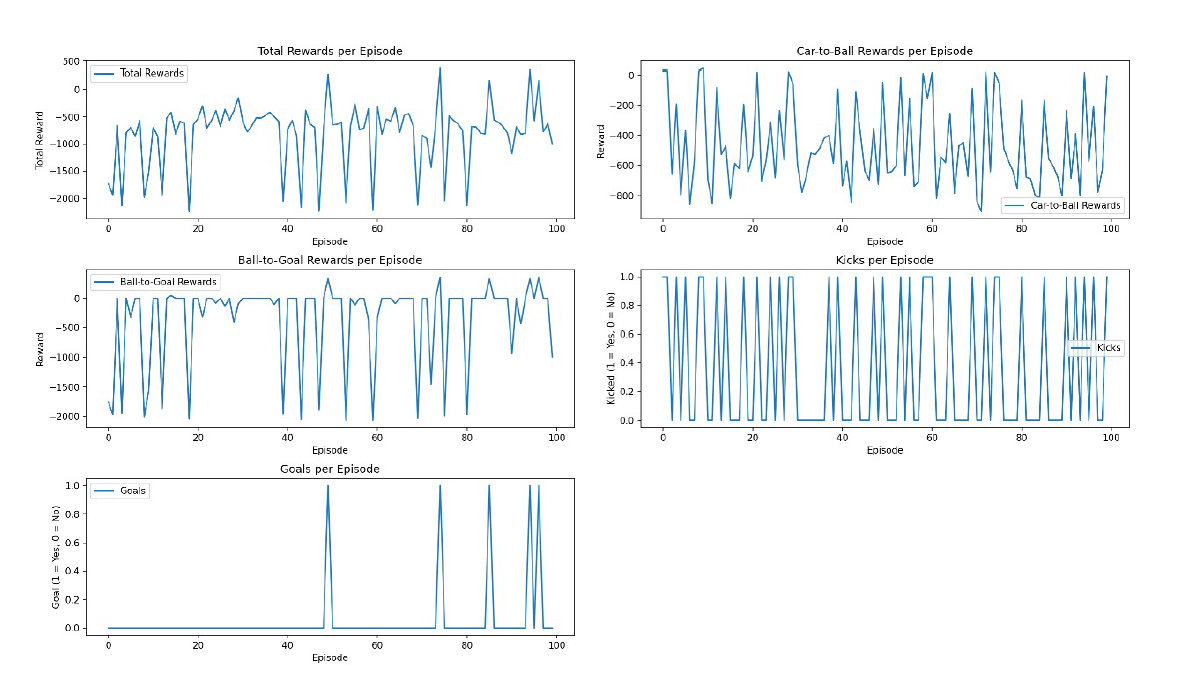

### 3) Final Version of the Custom 2D Football Environment (With Imitation Learning)

#### Environment

In [ ]:
# environment.py
import pygame
import numpy as np
import math

class Environment:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((800, 500))
        pygame.display.set_caption("Reinforcement Learning: Car and Ball")
        self.clock = pygame.time.Clock()

        # Goal position fixed
        self.goal_width, self.goal_height = 100, 200
        self.goal_x, self.goal_y = 750, 250

        # Load images
        self.car_image = pygame.image.load("car2.png")
        self.ball_image = pygame.image.load("ball.png")
        self.goal_image = pygame.image.load("goal2.png")
        self.background_image = pygame.image.load("field2.png")

        # Scale images
        self.car_image = pygame.transform.scale(self.car_image, (50, 25))
        self.ball_image = pygame.transform.scale(self.ball_image, (30, 30))
        self.goal_image = pygame.transform.scale(self.goal_image, (self.goal_width, self.goal_height))
        self.background_image = pygame.transform.scale(self.background_image, (800, 500))

        # Metrics
        self.episode = 0
        self.car_to_ball_reward = 0
        self.ball_to_goal_reward = 0
        self.step_reward = 0
        self.total_reward = 0
        self.kicked = False
        self.goal = False

        # Calculate initial distances
        self.goal_left = self.goal_x - self.goal_width // 2
        self.goal_right = self.goal_x + self.goal_width // 2
        self.goal_top = self.goal_y - self.goal_height // 2
        self.goal_bottom = self.goal_y + self.goal_height // 2

        self.reset()

    def reset(self):
        self.episode += 1
        # First, set the ball's position
        # self.ball_x, self.ball_y = self.randomize_ball()
        self.ball_x, self.ball_y = self.fixed_ball()
        # Now, randomize the car's position, ensuring it's not within 40 units of the ball
        self.car_x, self.car_y, self.car_angle = self.randomize_car()
        self.car_velocity = 0
        self.car_angular_velocity = 0
        self.ball_velocity_x = 0
        self.ball_velocity_y = 0
        self.kicked = False
        self.goal = False

        self.prev_car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        self.prev_ball_goal_dist = self.get_distance(self.ball_x, self.ball_y, self.goal_x, self.goal_y)

        self.car_to_ball_reward = 0
        self.ball_to_goal_reward = 0
        self.step_reward = 0
        self.total_reward = 0

        return self.get_state()

    def step(self, action):
        if not self.kicked:
            self.move_car(action)

        self.move_ball()
        self.handle_collisions()

        car_to_ball_reward_step = self.reward_car_to_ball() if not self.kicked else 0
        ball_to_goal_reward_step = self.reward_ball_to_goal() if self.kicked else 0

        self.car_to_ball_reward += car_to_ball_reward_step
        self.ball_to_goal_reward += ball_to_goal_reward_step
        self.step_reward = car_to_ball_reward_step + ball_to_goal_reward_step

        if self.kicked:
            self.car_velocity = 0
            self.car_angular_velocity = 0

        done = self.kicked and (abs(self.ball_velocity_x) < 0.1 and abs(self.ball_velocity_y) < 0.1 or self.goal)

        if done:
            self.total_reward = self.car_to_ball_reward + self.ball_to_goal_reward

        return self.get_state(), self.step_reward, done

    def reward_car_to_ball(self):
        car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        reward = 0

        if car_ball_dist > self.prev_car_ball_dist:
            reward -= 5  # Penalty for moving away from the ball
        elif car_ball_dist == self.prev_car_ball_dist:
            reward -= 0.1
        elif car_ball_dist < self.prev_car_ball_dist:
            reward += car_ball_dist * 0.01  # Reward for getting closer to the ball
            if car_ball_dist > 150:
                reward += -0.1  # Penalty for being far from the ball
            elif 100 < car_ball_dist <= 150:
                reward += 1  # Reward for getting closer to the ball
            elif 50 < car_ball_dist <= 100:
                reward += 2  # Reward for getting closer to the ball
            elif 35 < car_ball_dist <= 50:
                reward += 4  # Reward for getting closer to the ball
            elif car_ball_dist <= 35:
                reward += 15  # Reward for Kicking Ball
                print(f"Kicked the ball! Car-Ball Reward Step: {reward}")
                self.kicked = True
                angle = math.atan2(self.ball_y - self.car_y, self.ball_x - self.car_x)
                self.ball_velocity_x = math.cos(angle) * 7
                self.ball_velocity_y = math.sin(angle) * 7

        self.prev_car_ball_dist = car_ball_dist
        return reward

    def reward_ball_to_goal(self):
        ball_goal_dist = self.get_distance_to_outline_of_goal(self.ball_x, self.ball_y)
        reward = 0

        if ball_goal_dist < self.prev_ball_goal_dist:
            reward += (self.prev_ball_goal_dist - ball_goal_dist) * 0.5
        else:
            reward -= 10

        if self.check_goal():
            reward += 200
            print(f"Goal scored! Ball-Goal Reward Step: {reward}")
            self.ball_velocity_x = 0
            self.ball_velocity_y = 0
            self.goal = True

        self.prev_ball_goal_dist = ball_goal_dist
        return reward

    def check_goal(self):
        return self.goal_left <= self.ball_x <= self.goal_right and self.goal_top <= self.ball_y <= self.goal_bottom

    def randomize_car(self):
        while True:
            x = np.random.randint(300, 500)
            y = np.random.randint(150, 350)
            angle = np.random.uniform(0, 360)
            dist = self.get_distance(x, y, self.ball_x, self.ball_y)
            if dist >= 40:
                break
        return x, y, angle

    def randomize_ball(self):
        x = np.random.randint(250, 550)
        y = np.random.randint(150, 350)
        return x, y

    def fixed_ball(self):
        x = 400
        y = 250
        return x, y

    def get_distance(self, x1, y1, x2, y2):
        return math.hypot(x1 - x2, y1 - y2)

    def get_distance_to_outline_of_goal(self, x, y):
        calc_x = self.goal_left if x < self.goal_x else (x if x < self.goal_right else self.goal_right)  # Clamp x
        calc_y = self.goal_top if y < self.goal_y else (y if y < self.goal_bottom else self.goal_bottom) # Clamp y

        return self.get_distance(x, y, calc_x, calc_y)

    def get_state(self):
        car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        return np.array([
            self.car_x, self.car_y, self.car_velocity, self.car_angular_velocity, self.car_angle,
            self.ball_x, self.ball_y, car_ball_dist, 1 if self.ball_x < self.car_x else -1
        ])

    def handle_collisions(self):
        if self.ball_x - 15 < 0 or self.ball_x + 15 > 800:
            self.ball_velocity_x = -self.ball_velocity_x
        if self.ball_y - 15 < 0 or self.ball_y + 15 > 500:
            self.ball_velocity_y = -self.ball_velocity_y

    def move_car(self, action):
        car_speed = 5
        car_angular_speed = 5

        if action == 0:  # Forward
            self.car_velocity = car_speed
            self.car_angular_velocity = 0
        elif action == 1:  # Backward
            self.car_velocity = -car_speed
            self.car_angular_velocity = 0
        elif action == 2:  # Rotate Left
            self.car_velocity = 0
            self.car_angular_velocity = -car_angular_speed
        elif action == 3:  # Rotate Right
            self.car_velocity = 0
            self.car_angular_velocity = car_angular_speed
        elif action == 4:  # Forward + Left
            self.car_velocity = car_speed
            self.car_angular_velocity = -car_angular_speed
        elif action == 5:  # Forward + Right
            self.car_velocity = car_speed
            self.car_angular_velocity = car_angular_speed
        elif action == 6:  # Backward + Left
            self.car_velocity = -car_speed
            self.car_angular_velocity = -car_angular_speed
        elif action == 7:  # Backward + Right
            self.car_velocity = -car_speed
            self.car_angular_velocity = car_angular_speed
        elif action == 8:  # No Action
            self.car_velocity = 0
            self.car_angular_velocity = 0
        else:
            self.car_velocity = 0
            self.car_angular_velocity = 0

        self.car_angle += self.car_angular_velocity
        self.car_x += math.cos(math.radians(self.car_angle)) * self.car_velocity
        self.car_y += math.sin(math.radians(self.car_angle)) * self.car_velocity

    def move_ball(self):
        self.ball_x += self.ball_velocity_x
        self.ball_y += self.ball_velocity_y
        self.ball_velocity_x *= 0.98  # Friction
        self.ball_velocity_y *= 0.98  # Friction

    def render(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        self.screen.blit(self.background_image, (0, 0))
        rotated_goal = pygame.transform.rotate(self.goal_image, 0)
        self.screen.blit(rotated_goal, (self.goal_x - 50, self.goal_y - 100))
        self.screen.blit(self.ball_image, (self.ball_x - 15, self.ball_y - 15))
        rotated_car = pygame.transform.rotate(self.car_image, -self.car_angle)
        car_rect = rotated_car.get_rect(center=(self.car_x, self.car_y))
        self.screen.blit(rotated_car, car_rect.topleft)

        font = pygame.font.SysFont(None, 24)
        font2 = pygame.font.SysFont(None, 24,bold=True)

        # Display metrics
        episode_label = font2.render(f"Episode: {self.episode}", True, (0, 0, 0))
        step_label = font.render(f"Step Reward: {self.step_reward:.2f}", True, (0, 0, 0))
        car_to_ball_label = font.render(f"Car-Ball Reward: {self.car_to_ball_reward:.2f}", True, (0, 0, 0))
        ball_to_goal_label = font.render(f"Ball-Goal Reward: {self.ball_to_goal_reward:.2f}", True, (0, 0, 0))
        kicked_label = font.render(f"Kicked: {int(self.kicked)}", True, (55, 25, 100))
        goal_label = font.render(f"Goal: {int(self.goal)}", True, (25, 100, 80))

        # Render labels
        self.screen.blit(episode_label, (10, 10))
        self.screen.blit(step_label, (10, 40))
        self.screen.blit(car_to_ball_label, (10, 70))
        self.screen.blit(ball_to_goal_label, (10, 100))
        self.screen.blit(kicked_label, (10, 130))
        self.screen.blit(goal_label, (10, 160))

        pygame.display.flip()
        self.clock.tick(60)


#### Human Play for Recording Data for Imitation Learning

In [ ]:
# human_play.py
import pygame
import csv
import numpy as np

def main():
    """
    Human-controlled gameplay program.
    Allows human to play the game using W, A, S, D keys and records gameplay data.
    Finishes after 50 episodes.
    """
    env = Environment()
    clock = pygame.time.Clock()
    running = True
    max_episodes = 50  # Set the maximum number of episodes
    current_episode = 1  # Initialize the current episode counter

    # Open a CSV file to record data
    with open('gameplay_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        header = ['car_x', 'car_y', 'car_velocity', 'car_angular_velocity', 'car_angle',
                  'ball_x', 'ball_y', 'car_ball_dist', 'ball_relative_position',
                  'action', 'reward']
        writer.writerow(header)

        while running:
            action = 8  # Default action is 'No Action'
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            # Get keys
            keys = pygame.key.get_pressed()

            # Map keys to actions
            if keys[pygame.K_w] and keys[pygame.K_a]:
                action = 4  # Forward + Left
            elif keys[pygame.K_w] and keys[pygame.K_d]:
                action = 5  # Forward + Right
            elif keys[pygame.K_s] and keys[pygame.K_a]:
                action = 6  # Backward + Left
            elif keys[pygame.K_s] and keys[pygame.K_d]:
                action = 7  # Backward + Right
            elif keys[pygame.K_w]:
                action = 0  # Forward
            elif keys[pygame.K_s]:
                action = 1  # Backward
            elif keys[pygame.K_a]:
                action = 2  # Rotate Left
            elif keys[pygame.K_d]:
                action = 3  # Rotate Right
            else:
                action = 8  # No Action

            state = env.get_state()
            next_state, reward, done = env.step(action)
            env.render()

            # Record data
            writer.writerow(state.tolist() + [action, reward])

            clock.tick(60)

            if done:
                # Check if the maximum number of episodes has been reached
                if current_episode >= max_episodes:
                    print(f"Finished {max_episodes} episodes. Exiting the game.")
                    running = False
                else:
                    current_episode += 1  # Increment the episode counter
                    env.reset()

            if pygame.key.get_pressed()[pygame.K_ESCAPE]:
                running = False
                

    pygame.quit()

if __name__ == "__main__":
    main()


#### Preprocess Code for Converting Human Play Data to Trainable Data

In [ ]:
# preprocess.py
import numpy as np
import csv

def preprocess_data(filename):
    """
    Preprocesses the recorded gameplay data.
    Reads the data from the CSV file and prepares states and actions for training.
    """
    states = []
    actions = []

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip header
        for row in reader:
            state = [float(x) for x in row[:9]]
            action = int(row[9])

            states.append(state)
            actions.append(action)

    states = np.array(states)
    actions = np.array(actions)

    # Convert actions to one-hot encoding
    num_actions = 9  # Actions from 0 to 8
    actions_one_hot = np.zeros((len(actions), num_actions))
    actions_one_hot[np.arange(len(actions)), actions] = 1

    return states, actions_one_hot

if __name__ == "__main__":
    # Example usage
    states, actions_one_hot = preprocess_data('gameplay_data.csv')
    print("States shape:", states.shape)
    print("Actions shape:", actions_one_hot.shape)


#### Agent

In [ ]:
# agent.py
import random
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential #type: ignore
from tensorflow.keras.layers import Dense #type: ignore

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            tf.keras.Input(shape=(self.state_size,)),  # Define the input shape
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(self.action_size, activation="linear")
        ])
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.reshape(state, (1, self.state_size))  # Ensure correct shape
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, (1, self.state_size))  # Ensure correct shape
            next_state = np.reshape(next_state, (1, self.state_size))  # Ensure correct shape
            target = self.model.predict(state, verbose=0)[0]
            if done:
                target[action] = reward
            else:
                t = self.model.predict(next_state, verbose=0)[0]
                target[action] = reward + self.gamma * np.amax(t)
            target = np.reshape(target, (1, self.action_size))
            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def pretrain(self, states, actions_one_hot, epochs=10, batch_size=32):
        """
        Pretrain the model using supervised learning on the collected human gameplay data.
        """
        # Shuffle the data
        indices = np.arange(states.shape[0])
        np.random.shuffle(indices)
        states = states[indices]
        actions_one_hot = actions_one_hot[indices]

        self.model.fit(states, actions_one_hot, epochs=epochs, batch_size=batch_size, verbose=1)

    def save_model(self, name):
        """
        Saves the model to a file.
        """
        self.model.save(name)

    def load_model(self, name):
        """
        Loads the model from a file.
        """
        self.model = tf.keras.models.load_model(name)


#### Training Code

In [ ]:
# train_dqn.py
import threading
import numpy as np
import matplotlib.pyplot as plt
import preprocess  # Import the preprocess_data function
import pygame

def train_rl(agent, env, episodes, done_event, render_interval=50):
    rewards = []  # Total reward per episode
    car_to_ball_rewards = []  # Car-to-ball rewards per episode
    ball_to_goal_rewards = []  # Ball-to-goal rewards per episode
    kicks = []  # Whether the ball was kicked in the episode
    goals = []  # Whether the ball reached the goal in the episode

    for e in range(episodes):
        env.episode = e + 1
        state = env.reset()
        state = np.reshape(state, (1, agent.state_size))  # Ensure proper shape
        total_reward = 0
        kicked = 0  # Flag for ball kicked
        goal = 0  # Flag for goal achieved

        for _ in range(700):  # Increased episode steps
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, (1, agent.state_size))  # Ensure proper shape

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Track if the ball was kicked
            if not kicked and env.kicked:
                kicked = 1

            # Track if a goal was scored
            if env.check_goal():
                goal = 1

            if done:
                break

            if e % render_interval == 0:
                env.render()

        # Append metrics
        rewards.append(total_reward)
        car_to_ball_rewards.append(env.car_to_ball_reward)
        ball_to_goal_rewards.append(env.ball_to_goal_reward)
        kicks.append(kicked)
        goals.append(goal)

        # Console log for each episode
        print(
            f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}, "
            f"Car-Ball-Reward: {env.car_to_ball_reward:.2f}, "
            f"Ball-Goal-Reward: {env.ball_to_goal_reward:.2f}, "
            f"Kicked: {kicked}, Goal: {goal}"
        )

        # Replay and train
        agent.replay(32)

        # Save the model every 100 episodes
        save_interval = 100
        if e % save_interval == 0:
            agent.save_model(f"model_{e}.h5")
            print(f"Model saved as model_{e}.h5")

    done_event.set()

    # Plot Training Metrics
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.plot(rewards, label="Total Rewards")
    plt.title("Total Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(car_to_ball_rewards, label="Car-to-Ball Rewards")
    plt.title("Car-to-Ball Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(ball_to_goal_rewards, label="Ball-to-Goal Rewards")
    plt.title("Ball-to-Goal Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(kicks, label="Kicks")
    plt.title("Kicks per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Kicked (1 = Yes, 0 = No)")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(goals, label="Goals")
    plt.title("Goals per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Goal (1 = Yes, 0 = No)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Rendering function
def render_pygame(env, done_event):
    """
    Renders the Pygame environment.
    Keeps rendering until the `done_event` is set after training is complete.
    """
    while not done_event.is_set():
        env.render()

    pygame.quit()

if __name__ == "__main__":
    # Initialize environment and agent
    env = Environment()
    state_size = env.get_state().shape[0]
    action_size = 9  # Number of actions (0 to 8)
    agent = DQNAgent(state_size, action_size)
    episodes = 500

    # Pretraining phase
    states, actions_one_hot = preprocess.preprocess_data('gameplay_data.csv')
    print("Starting pretraining...")
    agent.pretrain(states, actions_one_hot, epochs=10, batch_size=32)
    agent.save_model('pretrained_model.h5')
    print("Pretraining completed and model saved as 'pretrained_model.h5'.")

    # Threading setup
    done_event = threading.Event()
    rl_thread = threading.Thread(target=train_rl, args=(agent, env, episodes, done_event))

    # Start training in a separate thread
    rl_thread.start()

    # Start rendering in the main thread
    render_pygame(env, done_event)


![trained with imitation.png](<attachment:trained with imitation.png>)
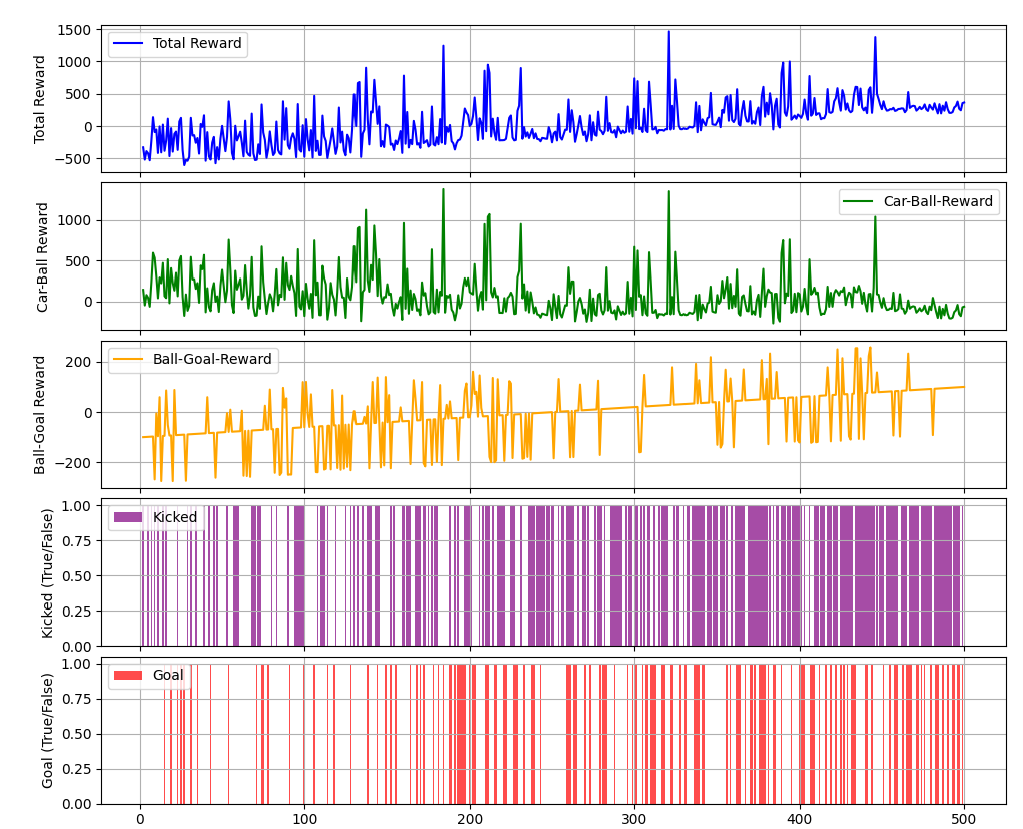